
## 一、项目背景介绍
我们在日常生活中每天都会吃很多肉，肉新鲜与否直接关系我们的身体健康，我们国家一直以来都是一个肉类生产、进口、消费大国，有大量的质检，人工质检不仅费时费力而且只能检查部分，效率低，通过计算机视觉的方法对肉的新鲜与否，可以大大提高效率，降低检查成本与时间，

## 二、数据介绍
## 数据集出处
>该数据集分为2类，新鲜和不新鲜的红肉，数据来源是 Izmir University of Economics大学2017年的团体作业，图像数据是通过ipl网络摄像机拍摄的。


## 数据集引用需要注明出处

```
@inproceedings{ulucan2019meat,
title={Meat quality assessment based on deep learning},
author={Ulucan, Oguzhan and Karakaya, Diclehan and Turkan, Mehmet},
booktitle={2019 Innovations in Intelligent Systems and Applications Conference (ASYU)},
pages={1--5},
year={2019},
organization={IEEE}
}
```

## 数据集大小
>像素1280 x 720.  1896 张l,各 948 

In [ ]:
# 解压缩数据集之 ~/dataset 目录
!unzip -qao data/data84831/Meat_Quality_Assessment_Dataset.zip -d dataset

In [ ]:
%cd ~
import imageio
import os
import matplotlib.pyplot as plt
%matplotlib inline

def print_meat(filepath):
    filename = os.listdir(filepath)
    ii=0
    for i in filename:
        ii=ii+1
        image = i.strip().split(".")  #这条语句完全是为了练习split方法。
        try:
            img = image[0]+".jpg"
            imag = os.path.join(filepath,img)
            im = imageio.imread(imag)
        except FileNotFoundError:
            print("出现一个文件读错误")
            img = image[0]+".PNG"
            imag = os.path.join(filepath,img)
            im = imageio.imread(imag)
        # else:
            # print("没有异常")
        if ii>4:
            break
        plt.imshow(im)
        plt.show()

/home/aistudio


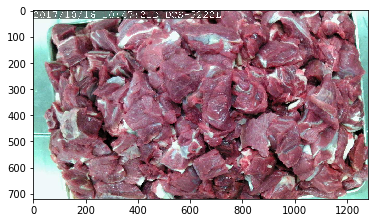

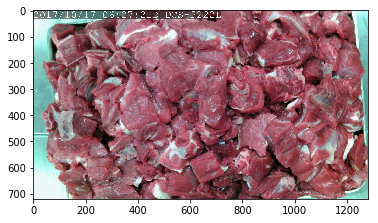

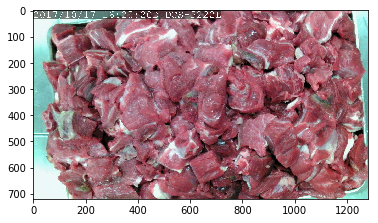

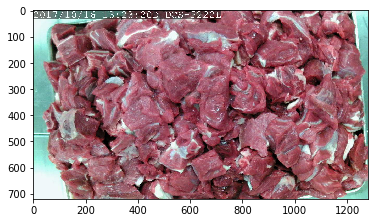

In [ ]:
# 查看新鲜猪肉图片
print_meat(filepath ="dataset/Fresh/")

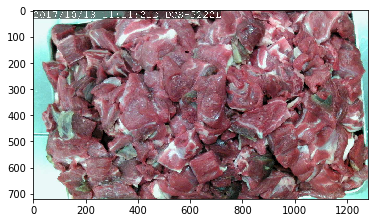

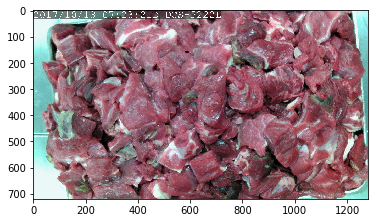

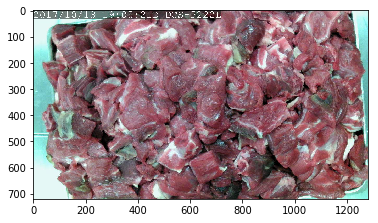

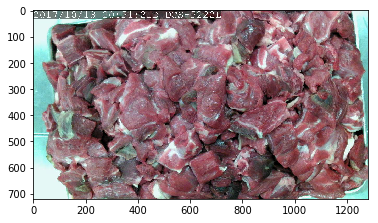

In [ ]:
# 查看不新鲜猪肉图片
print_meat(filepath ="dataset/Spoiled/")

## 三、模型介绍
## PaddleClas配置
### 使用PaddleClas/configs/MobileNetV3/MobileNetV3_large_x0_35.yaml
```
mode: 'train'
ARCHITECTURE:
    name: 'ResNet50_vd'
pretrained_model: "./pretrained/ResNet50_vd_pretrained"
model_save_dir: "./output/"
use_gpu: True
classes_num: 2
total_images: 1330
save_interval: 1
validate: True
valid_interval: 1
epochs: 20
topk: 2
image_shape: [3, 1280, 720]

LEARNING_RATE:
    function: 'Cosine'          
    params:                   
        lr: 0.00375

OPTIMIZER:
    function: 'Momentum'
    params:
        momentum: 0.9
    regularizer:
        function: 'L2'
        factor: 0.000001

TRAIN:
    batch_size: 128
    num_workers: 0
    file_list: "../dataset/train_list.txt"
    data_dir: "../dataset/"
    shuffle_seed: 0
    transforms:
        - DecodeImage:
            to_rgb: True
            to_np: False
            channel_first: False
        - RandCropImage:
            size: 224
        - RandFlipImage:
            flip_code: 1
        - NormalizeImage:
            scale: 1./255.
            mean: [0.485, 0.456, 0.406]
            std: [0.229, 0.224, 0.225]
            order: ''
        - ToCHWImage:

VALID:
    batch_size: 20
    num_workers: 0
    file_list: "../dataset/val_list.txt"
    data_dir: "../dataset/"
    shuffle_seed: 0
    transforms:
        - DecodeImage:
            to_rgb: True
            to_np: False
            channel_first: False
        # - ResizeImage:
        #     resize_short: 256
        - CropImage:
            size: 224
        - NormalizeImage:
            scale: 1.0/255.0
            mean: [0.485, 0.456, 0.406]
            std: [0.229, 0.224, 0.225]
            order: ''
        - ToCHWImage:
```

In [ ]:
# paddlex安装
!pip install paddlex -i https://mirror.baidu.com/pypi/simple

In [ ]:
# 划分好的数据集会额外生成labels.txt, train_list.txt, val_list.txt, test_list.txt四个文件，之后可直接进行训练
!paddlex --split_dataset --format ImageNet --dataset_dir dataset --val_value 0.2 --test_value 0.1

In [ ]:
# 克隆PaddleClas
!git clone https://gitee.com/paddlepaddle/PaddleClas.git --depth=1

In [8]:
# PaddleClas安装
%cd PaddleClas/
!pip3 install --upgrade -r requirements.txt -i https://mirror.baidu.com/pypi/simple

In [9]:
!mkdir pretrained && cd pretrained  && wget https://paddle-imagenet-models-name.bj.bcebos.com/dygraph/ResNet50_vd_pretrained.pdparams

## 四、模型训练
该部分主要是实践部分，也是相对来说话费时间最长的一部分，该部分主要展示模型训练的内容，同时向大家讲解模型参数的设置

In [10]:
# 采用刚刚的配置进行训练
!python3 tools/train.py -c ./configs/quick_start/ResNet50_vd_finetune.yaml

## 五、模型评估
该部分主要是对训练好的模型进行评估，可以是用验证集进行评估，或者是直接预测结果。评估结果和预测结果尽量展示出来，增加吸引力。

In [ ]:
!python tools/infer/infer.py \
    -i ../dataset/Fresh/test_20171017_172521D.jpg \
    --model ResNet50_vd \
    --pretrained_model "output/ResNet50_vd/19/ppcls" \
    --load_static_weights False \
    --class_num=2

![](https://ai-studio-static-online.cdn.bcebos.com/f0594a12e0ff4f3da62b26e00c5737ab9152350215b943bc97297a19a982532e)

```
Current image file: ../dataset/Fresh/test_20171017_172521D.jpg
	top1, class id: 0, probability: 0.7852
	top2, class id: 1, probability: 0.2148
```

In [ ]:
!python tools/infer/infer.py \
    -i ~/dataset/Spoiled/test_20171019_020321D.jpg \
    --model ResNet50_vd \
    --pretrained_model "output/ResNet50_vd/19/ppcls" \
    --load_static_weights False \
    --class_num=2

![](https://ai-studio-static-online.cdn.bcebos.com/5a2a59d402d146709d8fdd4b60b1ef0c1208d70cea55405c83b5e1943c595295)
```
Current image file: /home/aistudio/dataset/Spoiled/test_20171019_020321D.jpg
	top1, class id: 1, probability: 1.0000
	top2, class id: 0, probability: 0.0000
```

## 六、总结与升华
亮点：更快和更简单的过程——计算机视觉系统可以以更快的速度执行单调、重复的任务，使整个过程更简单
不足：
后续改进：

## 七、个人总结
兴趣方向；计算机视觉

[作者的个人主页链接](https://aistudio.baidu.com/aistudio/usercenter)

## 提交链接
[aistudio链接：](https://aistudio.baidu.com/aistudio/projectdetail/3526698)

[github链接：](http://)

[gitee链接：](http://)

In [11]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

In [12]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [13]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 